In [2]:
from __future__ import absolute_import, division, print_function

import gym_fishing
import matplotlib.pyplot as plt

import gym
import base64
import numpy as np
import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import q_network
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

In [26]:
#### Acitvate compatibility settings 
##tf.compat.v1.enable_v2_behavior()
### change default float
## tf.keras.backend.set_floatx('float64')

## Disable GPU, optional
#import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"


## Grow memory as needed instead of pre-allocating (e.g. allows concurrent GPU usage)
## (TF2 version.  See https://stackoverflow.com/a/59126638/258662)
# gpu_devices = tf.config.experimental.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(gpu_devices[0], True)

tf.version.VERSION

num_iterations = 20000             # @param {type:"integer"}
initial_collect_steps = 1000        # @param {type:"integer"} 
collect_steps_per_iteration = 1     # @param {type:"integer"}
replay_buffer_max_length = 200000  # @param {type:"integer"}
batch_size = 200                     # @param {type:"integer"}
learning_rate = 1e-3                # @param {type:"number"}
log_interval = 500                  # @param {type:"integer"}
num_eval_episodes = 100            # @param {type:"integer"}
eval_interval = 1000                # @param {type:"integer"}
discount = 0.99                     # @param {type: "float"}
                        
## Environment

env_name = 'fishing-v0'
env = suite_gym.load(env_name, discount = discount)
env.reset()


train_py_env = suite_gym.load(env_name, discount = discount)
eval_py_env = suite_gym.load(env_name, discount = discount)

#uses TFPyEnvironment wrapper to convert to tensors, so compatible with TF
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

fc_layer_params = (30,30)
q_net = q_network.QNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=fc_layer_params)

#changed optimizer syntax to ver 2.2.0 syntax, added lr exponential decay schedule
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=0.001,
#     decay_steps=1000,
#     decay_rate=0.09,
#     staircase=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()

eval_policy = agent.policy
collect_policy = agent.collect_policy

random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

# example_environment = tf_py_environment.TFPyEnvironment(
#     suite_gym.load(env_name, discount = discount))

# time_step = example_environment.reset()
# random_policy.action(time_step)

In [27]:
#@test {"skip": true}
def compute_avg_return(environment, policy, num_episodes=100):
    total_return = 0.0
    for _ in range(num_episodes):
        time_step = environment.reset()
        episode_return = 0.0
        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            episode_return += time_step.reward
        total_return += episode_return

    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]

#compute_avg_return(eval_env, random_policy, num_eval_episodes)

In [28]:
def simulate(environment, policy):
    total_return = 0.0
    time_step = environment.reset()
    episode_return = 0.0

    output = np.zeros(shape = (1000, 4))
    for it in range(1000):
        action_step = policy.action(time_step)
        time_step = environment.step(action_step.action)
        episode_return += time_step.reward
        output[it] = (it, time_step.observation, action_step.action, episode_return)

    return output

#out = simulate(eval_env, random_policy)



replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec = agent.collect_data_spec,
    batch_size = train_env.batch_size,
    max_length = replay_buffer_max_length)


#@test {"skip": true}
def collect_step(environment, policy, buffer):
    time_step = environment.current_time_step()
    action_step = policy.action(time_step)
    next_time_step = environment.step(action_step.action)
    traj = trajectory.from_transition(time_step, action_step, next_time_step)

  # Add trajectory to the replay buffer
    buffer.add_batch(traj)

def collect_data(env, policy, buffer, steps):
    for _ in range(steps):
        collect_step(env, policy, buffer)

collect_data(train_env, random_policy, replay_buffer, steps=100)

# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, 
    sample_batch_size=batch_size, 
    num_steps=2).prefetch(3)

iterator = iter(dataset)

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)
# Reset the train step
agent.train_step_counter.assign(0)
# Evaluate the agent's policy once before training.
# avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
# returns = [avg_return]




<tf.Variable 'UnreadVariable' shape=() dtype=int32, numpy=0>

step = 500: loss = 0.00029798492323607206
step = 1000: loss = 0.0006733463960699737
step = 1000: Average Return = 1.0419764518737793
step = 1500: loss = 0.0006147442036308348
step = 2000: loss = 0.0032725816126912832
step = 2000: Average Return = 2.753514289855957
step = 2500: loss = 0.02686837874352932
step = 3000: loss = 0.01006860937923193
step = 3000: Average Return = 24.385906219482422
step = 3500: loss = 0.007771049626171589
step = 4000: loss = 0.005936387926340103
step = 4000: Average Return = 24.502098083496094
step = 4500: loss = 0.009775999002158642
step = 5000: loss = 0.012310607358813286
step = 5000: Average Return = 24.405933380126953
step = 5500: loss = 0.009863805957138538
step = 6000: loss = 0.00748200761154294
step = 6000: Average Return = 24.22732925415039
step = 6500: loss = 0.012675737962126732
step = 7000: loss = 0.007186373695731163
step = 7000: Average Return = 24.290315628051758
step = 7500: loss = 0.007164540700614452
step = 8000: loss = 0.008986840024590492
st

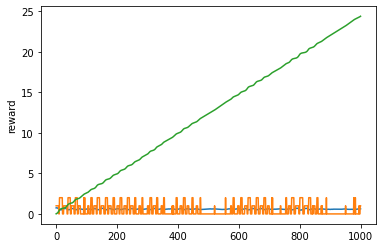

In [29]:
returns = []
for _ in range(num_iterations):
  # Collect a few steps using collect_policy and save to the replay buffer.
    for _ in range(collect_steps_per_iteration):
        collect_step(train_env, agent.collect_policy, replay_buffer)

  # Sample a batch of data from the buffer and update the agent's network.
    experience, unused_info = next(iterator)
    train_loss = agent.train(experience).loss

    step = agent.train_step_counter.numpy()

    if step % log_interval == 0:
        print('step = {0}: loss = {1}'.format(step, train_loss))

    if step % eval_interval == 0:
        avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
        print('step = {0}: Average Return = {1}'.format(step, avg_return))
        returns.append(avg_return)


### Simulate policy
out = simulate(eval_env, agent.policy)

## Plot
plt.plot(out[:,1])
plt.ylabel('state')
plt.savefig('state.png', bbox_inches='tight')

plt.plot(out[:,2])
plt.ylabel('action')
plt.savefig('action.png', bbox_inches='tight')

plt.plot(out[:,3])
plt.ylabel('reward')
plt.savefig('reward.png', bbox_inches='tight')


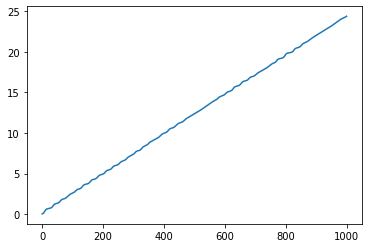

In [31]:
plt.plot(out[:,3])

In [34]:
len(out[:,3])

1000

In [35]:
returns

[1.0419765,
 2.7535143,
 24.385906,
 24.502098,
 24.405933,
 24.22733,
 24.290316,
 22.211319,
 23.646614,
 22.432066,
 9.093794,
 23.906078,
 23.86646,
 22.708559,
 23.672081,
 24.433935,
 3.550813,
 24.173302,
 24.203108,
 24.429798]

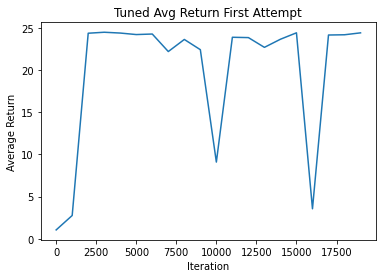

In [50]:
x = range(0,20000,1000)
plt.plot(x,returns)
plt.xlabel("Iteration")
plt.ylabel("Average Return")
plt.title("Tuned Avg Return First Attempt");
plt.savefig('tuned_reward.png', bbox_inches='tight')